# Exercise 1

The objective of this exercise is to model the power output of a turbine as a function of the wind speed. This is a very important problem, because it has a direct impact on the financial feasibility of the wind farm. As a result, it's been widely studied in the literature

Betz's theory establishes an upper limit to the efficiency of a wind turbine, based purely on the conservation of kinetic energy within the air stream. More sophisticated models also account for aerodynamic effects on the blade and conversion efficiency.

While these theoretical approaches offer a solid ground for the design of a wind farm, nothing beats the actual data that's collected from the operating turbines. In this exercise, we're going to try to model the performance of the turbines from collected data. Throughout the exercise, you'll learn about recognizing the negative impact of outliers, and different types of regresssion models.

In [1]:
# Import some useful libraries.

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
sns.set()

In [3]:
# Let's start by loading the data, as you've seen in the previous exercises.

df_prod = pd.read_csv('data-EDPR/data_wind_prod.csv', parse_dates=['Timestamp'], delimiter=';')
df_prod.set_index('Timestamp', drop=True, inplace=True)
df_prod.sort_index(inplace=True)
df_prod.sort_values(by = ['Timestamp', 'Turbine_ID'], inplace=True)

The main graphical representation we're going to be using throughout the exercise is the **power curve**: a plot of the power produced by the generator (y axis) as a function of the wind speed (x axis).

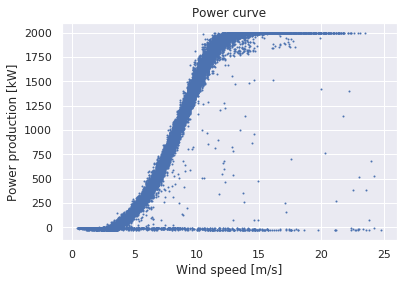

In [137]:
# Here's the code to plot the power curve.

fig, ax = plt.subplots()

ax.scatter(
    df_prod[df_prod["Turbine_ID"] == "T01"]["Amb_WindSpeed_Avg"],
    df_prod[df_prod["Turbine_ID"] == "T01"]["Grd_Prod_Pwr_Avg"],
    s=1
)
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
# _ = is a trick to stop jupyter from printing out text.
_ = ax.set_title("Power curve")

The majority of the points lies on a curve, with greater wind speed corresponding to greater output power (as expected). At very low wind speeds (roughly below 5 m/s), the generator doesn't produce any power because the blades don't have enough torque to spin it - this is called the *cut-in* wind speed. At high wind speeds, the output power stops increasing because there's only so much power the mechanical and electrical system can produce (around 2MW in the case of this turbine). There are also a bunch of other points that we'll say more about later in the exercise.

Our goal in this exercise is to be able to model the power curve based on the actual data collected from the towers, so that it can be compared with the theoretical model.

# Naive regression

Let's start with the most naive option of all, and try building a regression model based on a Neural Network. To keep things simple, we'll only look at the data from turbine 1, which you can find by selecting only rows where the `Turbine_ID` field is equal to `T01`.

The first step in any regression problem is to put together an *input* array (aka independent variable), and an *output* array (aka dependent variable). We'll call them `Xs` and `Ys`. To predict the power curve, our input is going to be the wind speed measured at the tower (`Amb_WindSpeed_Avg` field), and the output is going to be the power output (`Grd_Prod_Pwr_Avg` field).

In [117]:
# Assemble Xs and Ys by filtering `df_prod` to only include
# turbine no. 1, and extracting the relevant columns.

# begin your code

Xs = df_prod[df_prod["Turbine_ID"] == "T01"]["Amb_WindSpeed_Avg"]
Ys = df_prod[df_prod["Turbine_ID"] == "T01"]["Grd_Prod_Pwr_Avg"]

# end your code

print(f"{len(Xs)} input data points and {len(Ys)} output data points")

52244 input data points and 52244 output data points


Now that you've collected the complete training dataset, we need to split it into a *training* and a *testing* dataset. We'll set aside the testing dataset to measure the performance of the trained model. The idea is to select points randomly, so that the test set will be representative of all the conditions in the complete dataset.

Keep in mind that, in many situations, you'll want to actually split the dataset in *three* parts, setting aside a *validation* dataset that you can use to tweak the settings of the model without having to peek into the test dataset. We're not doing this in this problem to keep things simpler.

In [125]:
# Use the sklearn.model_selection.train_test_split function to split Xs and Ys
# into X_train, y_train, X_test, and y_test. Use 90% of the data points for
# training, and 10% for testing.

from sklearn.model_selection import train_test_split

# begin your code

X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.1)

# end your code

print(f"{len(X_train)} data points for training, {len(X_test)} data points for testing")

47019 data points for training, 5225 data points for testing


For our first experiment, we'll simply feed the training set to a Neural-Network based regression model. We'll also check its accuracy by checking its predictions on the test set.

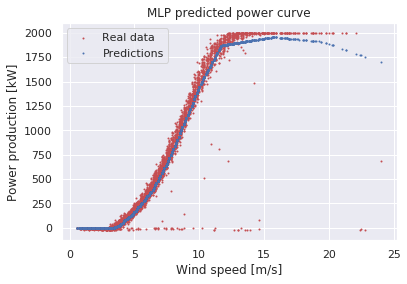

In [147]:
# Use the sklearn.neural_network.MLPRegressor class to train and test a regression model
# from Xs to Ys.
# Training will take a minute (depending on how fast your computer is).

from sklearn.neural_network import MLPRegressor

nn_regr_model = MLPRegressor(
    hidden_layer_sizes=(10,10,10,5),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=100,
    learning_rate_init=0.01,
    alpha=0.01
)

# begin your code

nn_regr_model.fit(X_train.values.reshape(-1, 1), y_train)
y_pred = nn_regr_model.predict(X_test.values.reshape(-1, 1))

# end your code

# Plot the predictions of the model for the test set against the 
# actual data.

fig, ax = plt.subplots()

ax.scatter(X_test, y_test, color='r', s=1, label='Real data')
ax.scatter(X_test, y_pred, color='b', s=1, label='Predictions')
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
ax.set_title("MLP predicted power curve")
_ = ax.legend()

At first glance, the neural network model is doing great: the predicted points (in blue) are a great match to the actual data in the testing set. However, if we look closely at the data, we'll find two groups of misbehaving data points:

- points with low output power even at high wind speeds (bottom right of the plot)
- points with medium output power at medium-high wind speeds (middle right of the plot)

Which turbine operating conditions do these points represent? Please try to think about some possible explanations before reading on.

Points with zero output power in windy conditions represent situations where the wind turbine was stopped (for example for repairs). Points with unexpectedly low output power are *transients*: temporary situations where the turbine is spinning up or recovering from an halt.

Our regression model completely ignored the difference between these operational regimes. Indeed, you can see that the model never predicts that the turbine is stopped or in a transient. Looking at the plot, there are no blue points in those regions. This happens because the vast majority of the points fall within the "standard" region, and thus the model only learns how to predict those.

It's intuitive that these "unconventional" points might also be degrading the accuracy of the model itself. Let's do some data cleaning to separate out those datapoints and improve the usefulness of our model.

We'll start by separating out the groups of "off" points (bottom of the plot) and the "max" points (top of the plot). This will allow us to train the model only on the points corresponding to the "operating" condition.

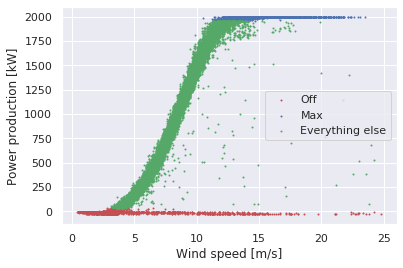

In [144]:
# Find a simple data-cleaning heuristic to separate "off", "max", and "std" datapoints.

# begin your code

off_threshold = 40 # kWh
max_threshold = 1960

# "off" points
off_condition = Ys < off_threshold
X_off, y_off = Xs[off_condition], Ys[off_condition]

# "max" points
max_condition = Ys > max_threshold
X_max, y_max = Xs[max_condition], Ys[max_condition]

# all other points
else_condition = (Ys >= off_threshold) & (Ys <= max_threshold)
X_else, y_else = Xs[else_condition], Ys[else_condition]

# end your code

fig, ax = plt.subplots()

ax.scatter(X_off, y_off, color='r', s=1, label='Off')
ax.scatter(X_max, y_max, color='b', s=1, label='Max')
ax.scatter(X_else, y_else, color='g', s=1, label='Everything else')
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
_ = ax.legend()

Now that we have a cleaner dataset that only covers the operational regime of the turbine, we can train a new regression model using only those datapoints.

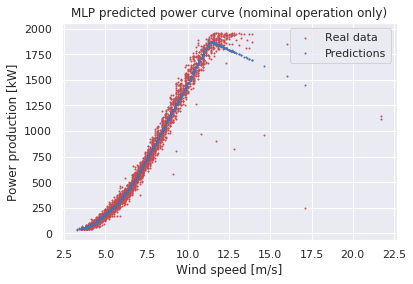

In [152]:
# Train a new regression model on the operational regime data.
# Don't forget to split the data in X_else_train and y_else_train

# begin your code

X_else_train, X_else_test, y_else_train, y_else_test = train_test_split(X_else, y_else, test_size=0.1)

nn_regr_model_else = MLPRegressor(
    hidden_layer_sizes=(10,10,5),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=100,
    learning_rate_init=0.01,
    alpha=0.01
)

# begin your code

nn_regr_model_else.fit(X_else_train.values.reshape(-1, 1), y_else_train)
y_else_pred = nn_regr_model_else.predict(X_else_test.values.reshape(-1, 1))

# end your code

# Plot the predictions of the model for the test set against the 
# actual data.

fig, ax = plt.subplots()

ax.scatter(X_else_test, y_else_test, color='r', s=1, label='Real data')
ax.scatter(X_else_test, y_else_pred, color='b', s=1, label='Predictions')
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
ax.set_title("MLP predicted power curve (nominal operation only)")
_ = ax.legend()

Even after selecting the datapoints that fall within the nominal region, it seems that the Neural Network is not the right kind of model for this task. You might be familiar with the concept of **generalization**: the Neural Network learns to fit the first part of the curve quite well, but is not expressive enough to fit the second part as well.

For this specific problem, we can take advantage of the fact that there is a clear underlying physical phenomenon behind the data points. The next section discusses how.

# Curve fitting

To improve our prediction performance, we can dust off one of the oldest and most basic tools of Machine Learning: **curve fitting** based on a Least Squares error. The insight is that the data points on the power curve follow a relatively simple relationship because they are just manifestations of a basic physical phenomenon (blades swept by the wing).

Therefore, we can look at all the data points in the training set as noisy measurements of a smooth curve. Our job in this section is to find the curve that best fits the data points in the training set, i.e. the one that does it with the smallest error.

The easiest way to describe a family of smooth curves is to pick a **polynomial**, one of the most basic curves in algebra. 

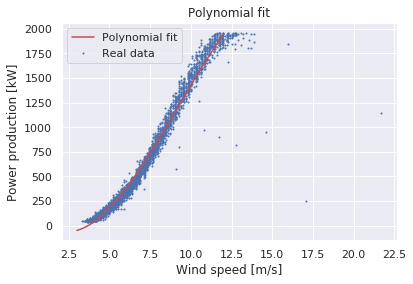

In [180]:
# Fit a degree 3 polynomial to the X_else training dataset.
# Then generate a list of 50 uniformly spaced points from 3 m/s to 12 m/s, and
# run it through the fitted polynomial (store the values in y_else_poly).

from numpy.polynomial import polynomial

# begin your code

# Fit polynomial.
coeffs = polynomial.polyfit(X_else_train, y_else_train, deg=3)

# Generate uniformly spaced points.
X_interp = np.linspace(3, 12, 50)

# Compute values assumed by the fitted polynomial.
y_interp = polynomial.polyval(X_interp, coeffs)

# end your code

fig, ax = plt.subplots()
ax.scatter(X_else_test, y_else_test, s=1, label="Real data")
ax.plot(X_interp, y_interp, color='r', label="Polynomial fit")
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
ax.set_title("Polynomial fit")
_ = ax.legend()

Thanks to its lower complexity compared to the Neural Network, the polynomial model doesn't have the incorrect behavior towards the top of the curve. As a side benefit, you'll have noticed how much faster it is to train than the neural network. Since the curve is much simpler to describe (only 4 parameters), it's also much more straightforward to use in Engineering calculations. 

# Classifying transient points

While we have been taking into account the "off" and "max" regimes of operation, we have completely ignored the transient regime. All those points in the middle right of the plot are decreasing the accuracy of our models, because they're skewing the polynomial towards the right. In this section, we're going to find a straightforward way to detect them and exclude them from the calculation.

The insight is to take the curve we have just fitted to the complete set of data points, and discard all points in the training set that lie too far away from it. We can then fit a new curve using only the inlier points. This concept of fitting a model, then finding the inliers, and fitting the model again is at the base of a very well-known family of algorithms called [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus).

In many cases, it's a good idea to repeat this 3-step process multiple times to minimize the impact of outliers. In this exercise, however, we're only going to do it once for simplicity.

# Identifying transient points

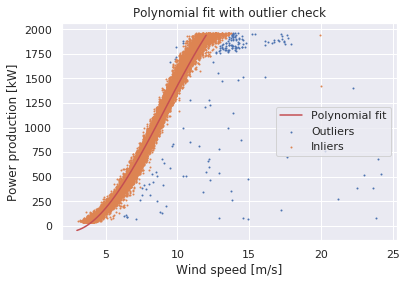

In [183]:
# Using the same polynomial that you fitted in the last exercise, compute the (squared) distance
# between the actual data and the polynomial fit.
#
# Find an appropriate threshold to tell inliers and outliers apart. You might find it helpful
# to plot the distribution of distance values.
#
# Store the *indices* of the points in inlier_indices and outlier_indices, so that you can
# use the plotting code below to visualize the results.

# begin your code

y_else_train_poly = polynomial.polyval(X_else_train, coeffs)
poly_dist = np.square(y_else_train - y_else_train_poly)

dist_threshold = 100 * 1000
inlier_indices = poly_error < dist_threshold
outlier_indices = np.logical_not(inlier_indices)

# end your code

fig, ax = plt.subplots()
ax.scatter(X_else_train[outlier_indices], y_else_train[outlier_indices], s=1, label="Outliers")
ax.scatter(X_else_train[inlier_indices], y_else_train[inlier_indices], s=1, label="Inliers")
ax.plot(X_interp, y_interp, color='r', label="Polynomial fit")
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
ax.set_title("Polynomial fit with outlier check")
_ = ax.legend()

You can see how the simplest distance metric can be an effective data cleaning tool, which is partially automated. 

# Wrapping up

Putting together all that we've done so far, we can visualize the different operating regimes of the generator.

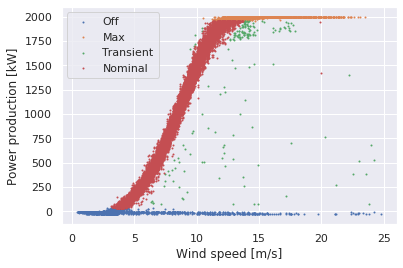

In [185]:
fig, ax = plt.subplots()

ax.scatter(X_off, y_off, s=1, label='Off')
ax.scatter(X_max, y_max, s=1, label='Max')
ax.scatter(X_else_train[outlier_indices], y_else_train[outlier_indices], s=1, label='Transient')
ax.scatter(X_else_train[inlier_indices], y_else_train[inlier_indices], s=1, label='Nominal')
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Power production [kW]")
_ = ax.legend()

# Identifying transient points

The goal of the exercise was to study and predict the power curve of a wind generation, i.e. the relationship between output power and wind speed.

We started the exercise by building a naive regression model based on Neural networks. While it seemed to work fairly well, it didn't account for the different operational regimes of the wind turbine. This led us to inject some of our domain knowledge about wind energy, and manually segment those different regimes, so that we could train our model on a more appropriate subset of the data.

Once we had a working regression model for the nominal operating region, we were able to also use it to classify data points in the "transient" region. Finally, these "refined" datapoints allowed us to create a very simple and compact polynomial model that could be used for approximate Engineering calculations about the power curve.

Throughout the exercise, you learned:
- how to load and extract data from a .csv file
- why and how to split your training dataset into training and testing
- how to set up and train a regresssion model based on Neural Networks
- how to manual data cleaning to improve the quality of the model
- how to fit a polynomial function to data points

# Identifying transient points

# Follow-up work

- We glossed over the details about the neural network used for regression. We encourage you to look up its [documentation]() and learn more about what each of the parameters does. You can tweak the architecture of the neural network itself, for example adding more layers or more neurons in each layers. You can also change the algorithm used during training.

- We used a single degree 3 polynomial for curve fitting. We encourage you to experiment with higher or lower degrees (keeping in mind that a degree 1 polynomial is a straight line). Polynomials with higher degree are prone to overfitting, while polynomials with a lower degree might not be expressive enough to capture all the information in the training data.